In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import re
from collections import deque
import datetime

<class 'list'>


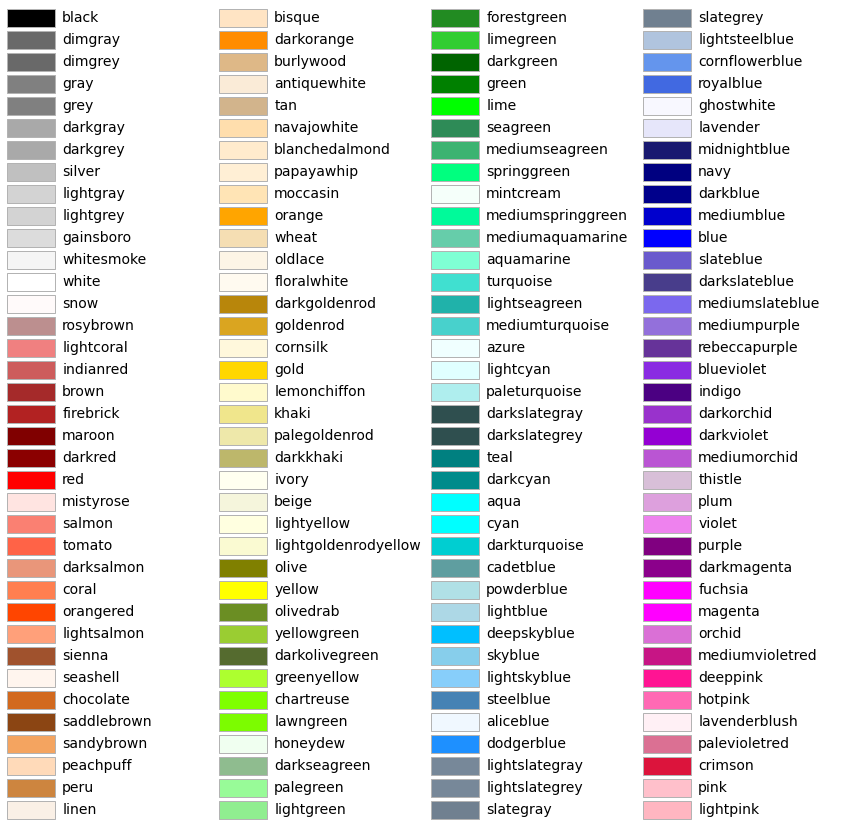

In [2]:
import math

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle


def plot_colortable(colors, *, ncols=4, sort_colors=True):
    color_list = []
    print(type(color_list))
    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')
        color_list.append(name)
        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return color_list

color_list = plot_colortable(mcolors.CSS4_COLORS)


## 1. 파일호출

In [3]:
# 파일 불러오기
with open('../../data/df_user.pkl', 'rb') as f:
    df_user = pickle.load(f)

In [4]:
# 파일 불러오기
with open('../../data/df_body.pkl', 'rb') as f:
    df_body = pickle.load(f)


In [5]:
# 파일 불러오기
with open('../../data/df_answer_cnt.pkl', 'rb') as f:
    df_answer_cnt = pickle.load(f)

In [6]:
# 파일 불러오기
with open('../../data/df_active_usr_per_year.pkl', 'rb') as f:
    df_active_usr_per_year = pickle.load(f)

In [7]:
# 파일 불러오기
with open('../../data/df_active_usr_per_day.pkl', 'rb') as f:
    df_active_usr_per_day = pickle.load(f)

In [8]:
# 파일 불러오기
with open('../../data/df_uuser_per_post.pkl', 'rb') as f:
    df_uuser_per_post = pickle.load(f)

In [9]:
# 파일 불러오기
with open('../../data/df_uuser_per_year.pkl', 'rb') as f:
    df_uuser_per_year = pickle.load(f)

In [10]:
df_body['date'] = df_body['creationdate'].dt.date
df_body['year'] = df_body['creationdate'].dt.year
df_body['month'] = df_body['creationdate'].dt.month
df_body['day'] = df_body['creationdate'].dt.day

##  1) 내부의 호혜성을 망가뜨리는지 

### Number of Questions and Answers over time

In [11]:
# Q&A 만 추출 
df_body = df_body[df_body['posttypeid'].isin(['1','2'])]

In [12]:
df_body.head()

,creationdate,id,posttypeid,title,owneruserid,body,answered_yn,date,year,month,day
0,2023-10-26 15:34:53.830,77368423,2,None,508057.0,"<p>If all machines are on the same LAN, then y...",0,2023-10-26,2023,10,26
1,2023-11-01 08:52:42.577,77401389,1,Unable to do File Upload using sendkeys method...,22838353.0,<p>I am trying to automate a webpage using Sel...,0,2023-11-01,2023,11,1
2,2023-10-30 14:32:47.247,77389520,1,Run macro based on cell contents if cell changes,22828175.0,<p>I want to run a macro if a cell changes bas...,0,2023-10-30,2023,10,30
3,2023-10-30 14:36:20.843,77389551,2,None,12500315.0,<p>Whilst you <em>could</em> write your own wr...,0,2023-10-30,2023,10,30
4,2023-10-23 09:20:47.107,77344034,1,Asp.Net chunking cookie issue,3365923.0,<p>I am using ASP.NET Identity. The login app ...,0,2023-10-23,2023,10,23


In [13]:
df_qna_num = df_body.groupby(['date', 'posttypeid']).count()[['id']].reset_index()

In [14]:
df_qna_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7364 entries, 0 to 7363
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        7364 non-null   object
 1   posttypeid  7364 non-null   object
 2   id          7364 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 172.7+ KB


In [15]:
df_qna_num.date = pd.to_datetime(df_qna_num.date)

In [16]:
df_bodycnt = df_body.groupby(['date', 'posttypeid']).count()[['id']].reset_index()

In [17]:
df_bodycnt = pd.pivot_table(df_bodycnt, index = 'date', columns = 'posttypeid', values = 'id').reset_index()

In [18]:
df_bodycnt['q_over_a'] = df_bodycnt['2'].div(df_bodycnt['1'])

### Question over Answer

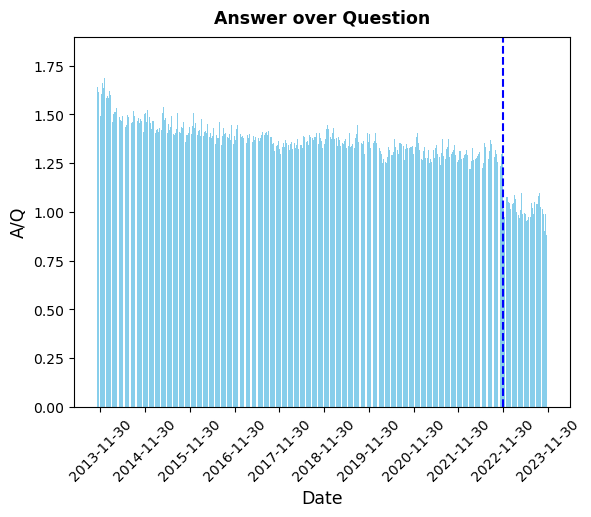

In [19]:
fig, ax = plt.subplots()


ax.bar(df_bodycnt.date
    ,  height = df_bodycnt['q_over_a']
    ,  color = 'skyblue'
    ,  label = 'Mean'
    # ,  edgecolor = 'black'
      ) # hist type

ax.set_title("Answer over Question", # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')
ax.set_xlabel("Date", # add x-axis label
              fontsize = 12.5)
ax.set_ylabel("A/Q", # add y-axis label
              fontsize = 12.5)

major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
ax.set_xticks(major_xticks)

ax.axvline(['2022-11-30'], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)
plt.xticks(rotation=45)
plt.show();



In [20]:
df_bodyanswerdyn = df_body[df_body['posttypeid'] =='1'].groupby(['date', 'answered_yn']).count()[['id']].reset_index()

In [21]:
df_bodyanswerdyn = pd.pivot_table(df_bodyanswerdyn, index = 'date', columns = 'answered_yn', values = 'id').reset_index()

In [22]:
df_bodyanswerdyn['rate'] = df_bodyanswerdyn[1] / (df_bodyanswerdyn[1] + df_bodyanswerdyn[0])

### Ratio of Answered Question

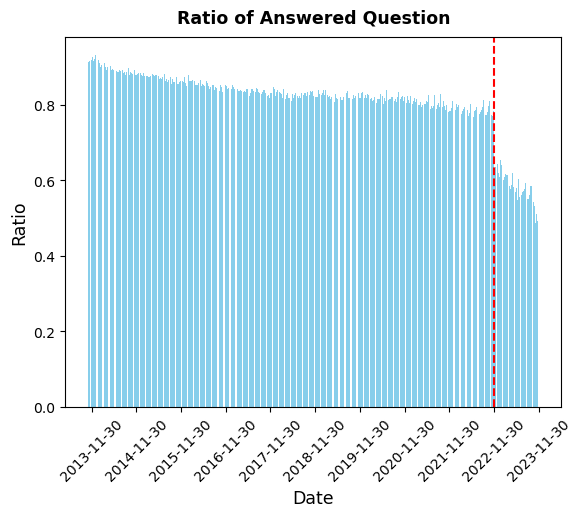

In [23]:
fig, ax = plt.subplots()


ax.bar(df_bodyanswerdyn.date
    ,  height = df_bodyanswerdyn['rate']
    ,  color = 'skyblue'
    ,  label = 'Mean'
    # ,  edgecolor = 'black'
      ) # hist type

ax.set_title("Ratio of Answered Question", # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')
ax.set_xlabel("Date", # add x-axis label
              fontsize = 12.5)
ax.set_ylabel("Ratio", # add y-axis label
              fontsize = 12.5)

major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
ax.set_xticks(major_xticks)

ax.axvline(['2022-11-30'], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)
plt.xticks(rotation=45)
plt.show();

### Answer Count line plot

In [24]:
df_answer_cnt

,year,id,cnt
0,2019,58652589,1
1,2019,58652591,0
2,2019,58652594,1
3,2019,58652601,1
4,2019,58652602,0
...,...,...,...
594474,2023,77582335,0
594475,2023,77582336,1
594476,2023,77582339,1
594477,2023,77582341,2


In [25]:
df_answer_cnt.loc[(df_answer_cnt['year']== '2020'), 'cnt'].value_counts().sort_index().to_frame()['count']

cnt
0     30669
1     77741
2     20824
3      4912
4      1181
5       310
6        80
7        24
8         8
9         7
10        1
11        1
12        3
13        1
14        1
Name: count, dtype: int64

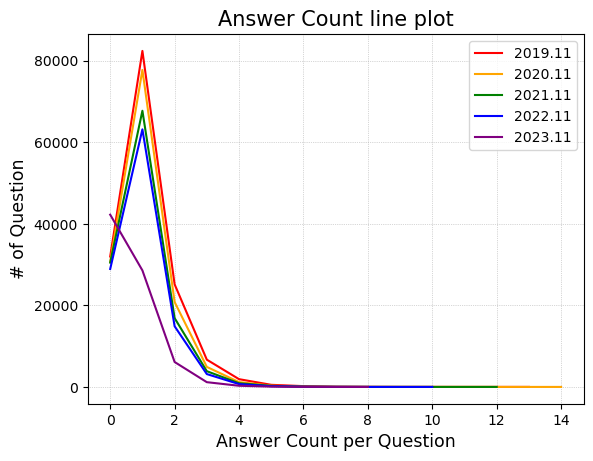

In [26]:
fig, ax = plt.subplots()


ax.plot(df_answer_cnt.loc[(df_answer_cnt['year']== '2019'), 'cnt'].value_counts().sort_index().to_frame()['count'].values, # specify data
        color = 'red',
        label = '2019.11'
) 

ax.plot(df_answer_cnt.loc[(df_answer_cnt['year']== '2020'), 'cnt'].value_counts().sort_index().to_frame()['count'].values, # specify data
        color = 'orange',
        label = '2020.11'
) 

ax.plot(df_answer_cnt.loc[(df_answer_cnt['year']== '2021'), 'cnt'].value_counts().sort_index().to_frame()['count'].values, # specify data
        color = 'green',
        label = '2021.11'
# label = ['question', 'answer']
) # create legened labels

ax.plot(df_answer_cnt.loc[(df_answer_cnt['year']== '2022'), 'cnt'].value_counts().sort_index().to_frame()['count'].values, # specify data
        color = 'blue',
         label = '2022.11'
        # label = ['question', 'answer']
        ) # create legened labels

ax.plot(df_answer_cnt.loc[(df_answer_cnt['year']== '2023'), 'cnt'].value_counts().sort_index().to_frame()['count'].values, # specify data
        color = 'purple', # bar color
        label = '2023.11'
        ) # create legened labels





ax.set_title('Answer Count line plot', fontsize = 15) # title
ax.set_xlabel('Answer Count per Question', fontsize = 12.5) # x-axis label
ax.set_ylabel('# of Question', fontsize = 12.5) # y-axis label

ax.legend(loc = 'upper right', fontsize = 10) # add legend

ax.grid(True, linestyle = ':', linewidth = 0.5) # grid

plt.show();

##  2) 소수의 활발한 대화

### a) 한 달 동안 활동한 Unique user 수가 줄어들고 있는지

In [27]:
df_active_usr_per_day


df_active_usr_per_day_tot = df_active_usr_per_day.groupby(['creationdate']).sum()['usr_cnt'].reset_index()


In [28]:
df_active_usr_per_day_tot = df_active_usr_per_day_tot[df_active_usr_per_day_tot['creationdate'] >='2013-11-30']

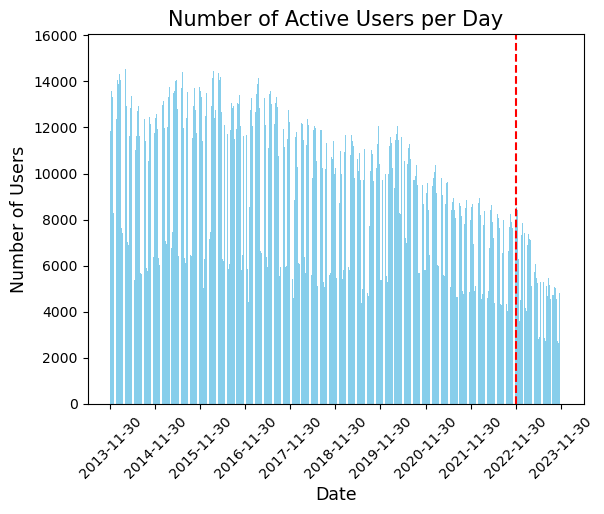

In [29]:
fig, ax = plt.subplots()


# ax.plot( df_active_usr_per_day_tot.creationdate, 
#         df_active_usr_per_day_tot['usr_cnt'].values, # specify data
#         color = 'green',
#         label = 'Total'
# ) 

ax.bar(df_active_usr_per_day_tot.creationdate
    ,  height = df_active_usr_per_day_tot['usr_cnt']
    ,  color = 'skyblue'
    # ,  label = 'Mean'
    # ,  edgecolor = 'black'
      ) # hist type


major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
ax.set_xticks(major_xticks)

ax.set_title('Number of Active Users per Day', fontsize = 15) # title
ax.set_xlabel('Date', fontsize = 12.5) # x-axis label
ax.set_ylabel('Number of Users', fontsize = 12.5) # y-axis label

# ax.legend(loc = 'upper right', fontsize = 10) # add legend


ax.axvline('2022-11-30', # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)

plt.xticks(rotation=45)
plt.show();

In [30]:
df_active_usr_per_day =df_active_usr_per_day[df_active_usr_per_day['creationdate']>= '2013-11-30']

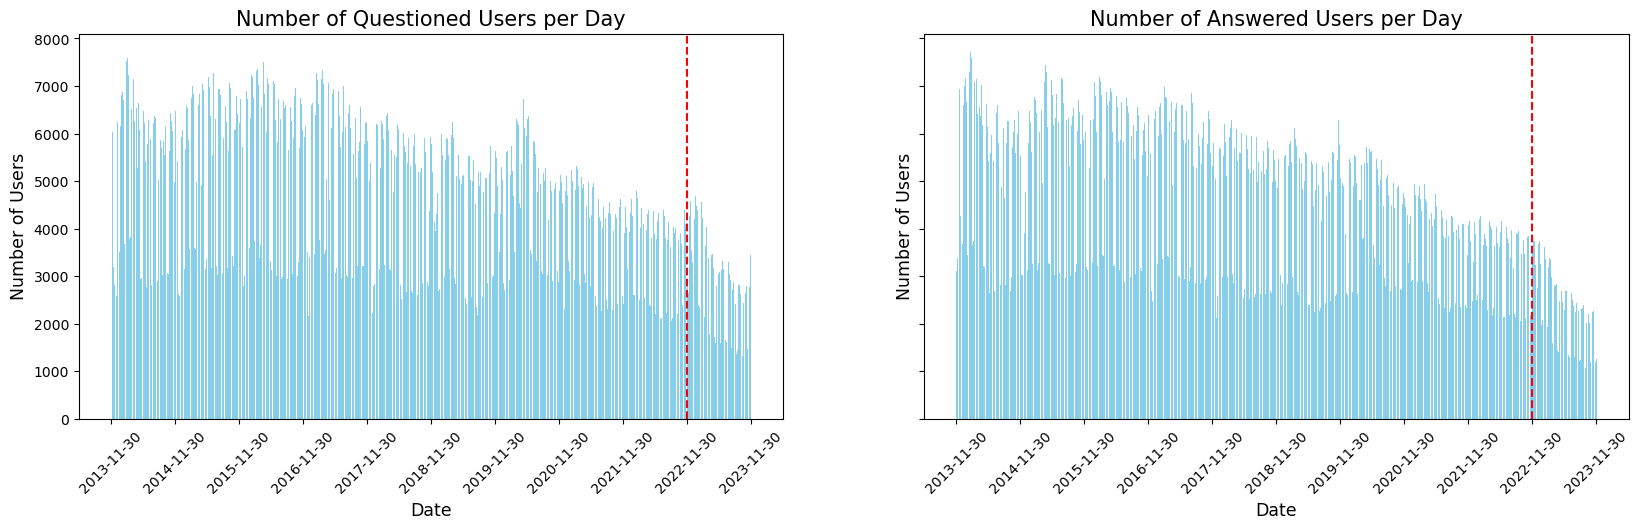

In [31]:
sharey = True ## 또는 sharey=False
sharex = True ## 또는 sharex=False


major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']

fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharey=sharey, sharex=sharex)


axs[0].bar(df_active_usr_per_day_tot.creationdate
    ,  height = df_active_usr_per_day.loc[df_active_usr_per_day['posttypeid'] =='1', 'usr_cnt']
    ,  color = 'skyblue'
      ) # hist type

axs[1].bar(df_active_usr_per_day_tot.creationdate
    ,  height = df_active_usr_per_day.loc[df_active_usr_per_day['posttypeid'] =='2', 'usr_cnt']
    ,  color = 'skyblue'
      ) # hist type

axs[0].set_xticks(major_xticks)
axs[0].set_title('Number of Questioned Users per Day', fontsize = 15) # title
axs[0].set_xlabel('Date', fontsize = 12.5) # x-axis label
axs[0].set_ylabel('Number of Users', fontsize = 12.5) # y-axis label
axs[0].axvline('2022-11-30', # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)
axs[0].tick_params(axis='x', rotation=45)

axs[1].set_xticks(major_xticks)
axs[1].set_title('Number of Answered Users per Day', fontsize = 15) # title
axs[1].set_xlabel('Date', fontsize = 12.5) # x-axis label
axs[1].set_ylabel('Number of Users', fontsize = 12.5) # y-axis label
axs[1].axvline('2022-11-30', # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)
axs[1].tick_params(axis='x', rotation=45)

plt.show();

### b) Number of questions/answers per unique user 가 늘어나는지

In [32]:
# df_uuser_per_post['cdate'] = pd.to_datetime(df_uuser_per_post['cdate'])

In [33]:
df_uuser_per_post = df_uuser_per_post.sort_values(by = 'cdate')

In [34]:
df_uuser_per_post = df_uuser_per_post[df_uuser_per_post['cdate'] >='2013-11-30']

In [35]:
df_uuser_per_post

,cdate,posttypeid,avg_q_cnt,med_q_cnt
337,2013-11-30,2,1.7726276229251488,1.00000000000000000000
1142,2013-11-30,1,1.1048411964230651,1.00000000000000000000
1622,2013-12-01,1,1.1075572279711508,1.00000000000000000000
1120,2013-12-01,2,1.7085072231139647,1.00000000000000000000
1342,2013-12-02,1,1.0873884492338778,1.00000000000000000000
...,...,...,...,...
10398,2023-12-01,1,1.0176570458404075,1.00000000000000000000
7197,2023-12-02,2,1.2650793650793651,1.00000000000000000000
7192,2023-12-02,1,1.0288000000000000,1.00000000000000000000
4809,2023-12-03,2,1.1681818181818182,1.00000000000000000000


In [36]:
df_uuser_per_q = df_uuser_per_post[df_uuser_per_post['posttypeid'] =='1']
df_uuser_per_a = df_uuser_per_post[df_uuser_per_post['posttypeid'] =='2']

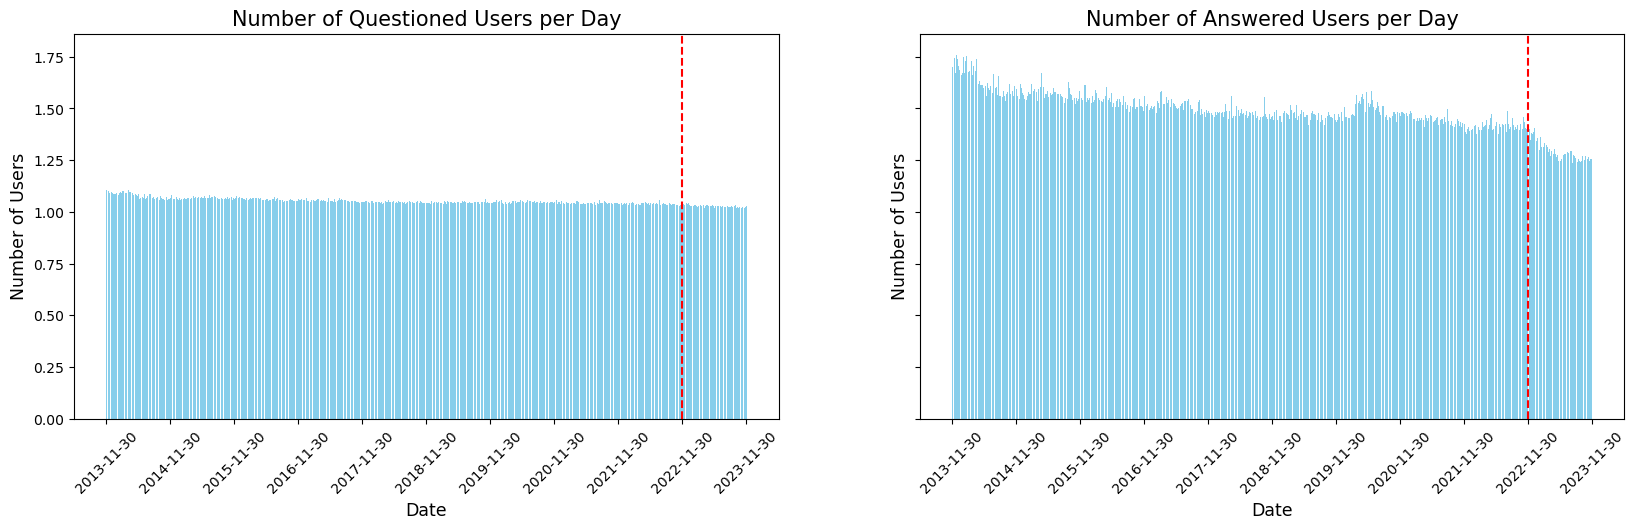

In [37]:
sharey = True ## 또는 sharey=False
sharex = True ## 또는 sharex=False


major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']

fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharey=sharey, sharex=sharex)


axs[0].bar(df_uuser_per_q.cdate
    ,  height = df_uuser_per_q['avg_q_cnt']
    ,  color = 'skyblue'
      ) # hist type

axs[1].bar(df_uuser_per_a.cdate
    ,  height = df_uuser_per_a['avg_q_cnt']
    ,  color = 'skyblue'
      ) # hist type

axs[0].set_xticks(major_xticks)
axs[0].set_title('Number of Questioned Users per Day', fontsize = 15) # title
axs[0].set_xlabel('Date', fontsize = 12.5) # x-axis label
axs[0].set_ylabel('Number of Users', fontsize = 12.5) # y-axis label
axs[0].axvline('2022-11-30', # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)
axs[0].tick_params(axis='x', rotation=45)

axs[1].set_xticks(major_xticks)
axs[1].set_title('Number of Answered Users per Day', fontsize = 15) # title
axs[1].set_xlabel('Date', fontsize = 12.5) # x-axis label
axs[1].set_ylabel('Number of Users', fontsize = 12.5) # y-axis label
axs[1].axvline('2022-11-30', # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)
axs[1].tick_params(axis='x', rotation=45)

plt.show();

In [44]:
df_uuser_per_year = df_uuser_per_year[df_uuser_per_year['post_cnt']>10]

In [45]:
cond1 = df_uuser_per_year['posttypeid']  =='1'
cond2 = df_uuser_per_year['posttypeid']  =='2'
cond3 = df_uuser_per_year['postcreationyear']  == '2019'
cond4 = df_uuser_per_year['postcreationyear']  =='2020'
cond5 = df_uuser_per_year['postcreationyear']  =='2021'
cond6 = df_uuser_per_year['postcreationyear']  =='2022'
cond7 = df_uuser_per_year['postcreationyear']  =='2023'

In [46]:
df_uuser_per_year[cond1 & cond3]

,postcreationyear,posttypeid,post_cnt,value
5636,2019,1,11,2718
5637,2019,1,12,2174
5638,2019,1,13,1724
5639,2019,1,14,1469
5640,2019,1,15,1224
...,...,...,...,...
5790,2019,1,233,1
5791,2019,1,234,1
5792,2019,1,236,1
5793,2019,1,245,1


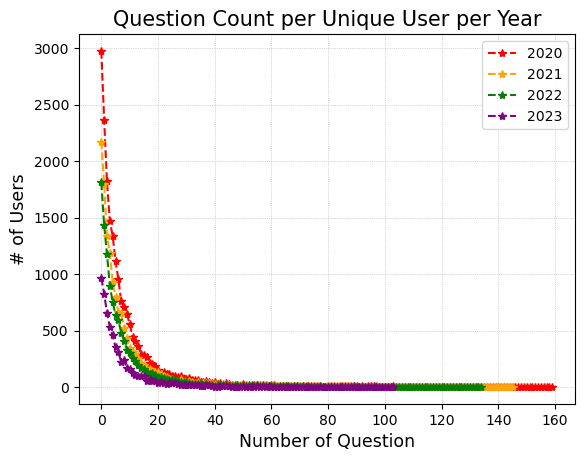

In [57]:
fig, ax = plt.subplots()


ax.plot(df_uuser_per_year.loc[cond1 & cond4, 'value'].values, # specify data
        color = 'red',
        label = '2020',
        marker='*',
        linestyle='--'
) 


ax.plot(df_uuser_per_year.loc[cond1 & cond5, 'value'].values, # specify data
        color = 'orange',
        label = '2021',
        marker='*',
        linestyle='--'
) 


ax.plot(df_uuser_per_year.loc[cond1 & cond6, 'value'].values, # specify data
        color = 'green',
        label = '2022',
        marker='*',
        linestyle='--'
) 

ax.plot(df_uuser_per_year.loc[cond1 & cond7, 'value'].values, # specify data
        color = 'purple',
        label = '2023',
        marker='*',
        linestyle='--'
) 


ax.set_title('Question Count per Unique User per Year', fontsize = 15) # title
ax.set_xlabel('Number of Question', fontsize = 12.5) # x-axis label
ax.set_ylabel('# of Users', fontsize = 12.5) # y-axis label

ax.legend(loc = 'upper right', fontsize = 10) # add legend

ax.grid(True, linestyle = ':', linewidth = 0.5) # grid

plt.show();

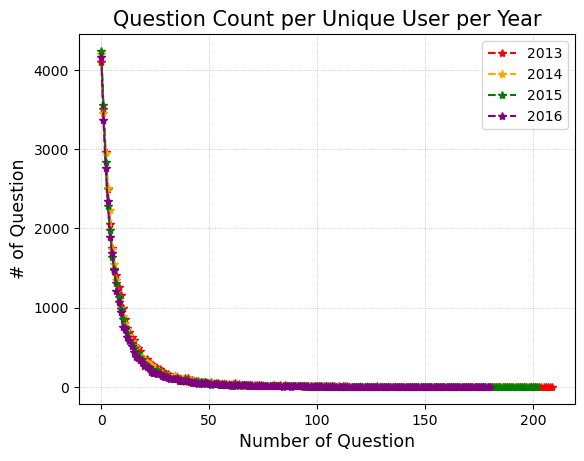

In [48]:
fig, ax = plt.subplots()


ax.plot(df_uuser_per_year.loc[cond1 & (df_uuser_per_year['postcreationyear']  =='2013'), 'value'].values, # specify data
        color = 'red',
        label = '2013',
        marker='*',
        linestyle='--'
) 


ax.plot(df_uuser_per_year.loc[cond1 & (df_uuser_per_year['postcreationyear']  =='2014'), 'value'].values, # specify data
        color = 'orange',
        label = '2014',
        marker='*',
        linestyle='--'
) 


ax.plot(df_uuser_per_year.loc[cond1 & (df_uuser_per_year['postcreationyear']  =='2015'), 'value'].values, # specify data
        color = 'green',
        label = '2015',
        marker='*',
        linestyle='--'
) 

ax.plot(df_uuser_per_year.loc[cond1 & (df_uuser_per_year['postcreationyear']  =='2016'), 'value'].values, # specify data
        color = 'purple',
        label = '2016',
        marker='*',
        linestyle='--'
) 


ax.set_title('Question Count per Unique User per Year', fontsize = 15) # title
ax.set_xlabel('Number of Question', fontsize = 12.5) # x-axis label
ax.set_ylabel('# of Question', fontsize = 12.5) # y-axis label

ax.legend(loc = 'upper right', fontsize = 10) # add legend

ax.grid(True, linestyle = ':', linewidth = 0.5) # grid

plt.show();

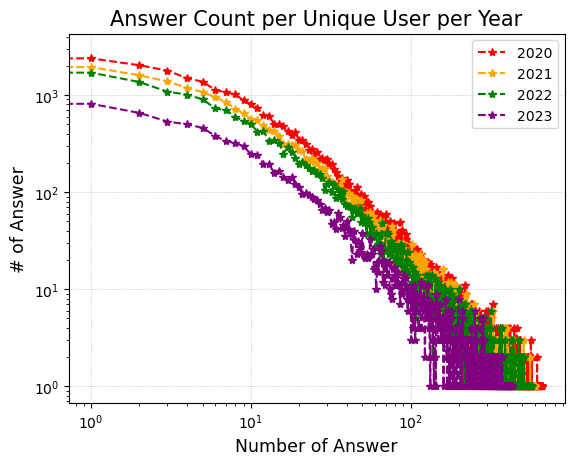

In [54]:
fig, ax = plt.subplots()


ax.plot(df_uuser_per_year.loc[cond2 & cond4, 'value'].values, # specify data
        color = 'red',
        label = '2020',
        marker='*',
        linestyle='--',
) 


ax.plot(df_uuser_per_year.loc[cond2 & cond5, 'value'].values, # specify data
        color = 'orange',
        label = '2021',
        marker='*',
        linestyle='--'
) 


ax.plot(df_uuser_per_year.loc[cond2 & cond6, 'value'].values, # specify data
        color = 'green',
        label = '2022',
        marker='*',
        linestyle='--'
) 

ax.plot(df_uuser_per_year.loc[cond2 & cond7, 'value'].values, # specify data
        color = 'purple',
        label = '2023',
        marker='*',
        linestyle='--'
) 


ax.set_title('Answer Count per Unique User per Year', fontsize = 15) # title
ax.set_xlabel('Number of Answer', fontsize = 12.5) # x-axis label
ax.set_ylabel('# of Answer', fontsize = 12.5) # y-axis label

ax.legend(loc = 'upper right', fontsize = 10) # add legend

ax.grid(True, linestyle = ':', linewidth = 0.5) # grid
plt.yscale('log');
plt.xscale('log');
plt.show();

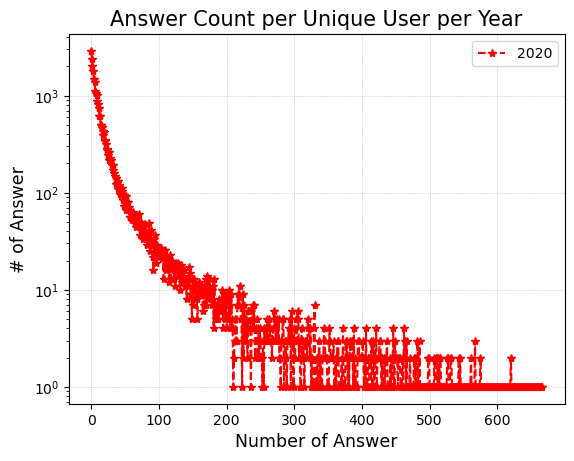

In [56]:
fig, ax = plt.subplots()


ax.plot(df_uuser_per_year.loc[cond2 & cond4, 'value'].values, # specify data
        color = 'red',
        label = '2020',
        marker='*',
        linestyle='--',
) 

ax.set_title('Answer Count per Unique User per Year', fontsize = 15) # title
ax.set_xlabel('Number of Answer', fontsize = 12.5) # x-axis label
ax.set_ylabel('# of Answer', fontsize = 12.5) # y-axis label

ax.legend(loc = 'upper right', fontsize = 10) # add legend

ax.grid(True, linestyle = ':', linewidth = 0.5) # grid
plt.yscale('log');
# plt.xscale('log');
plt.show();